# Forecasting electricity load without changepoints


## Code

##### Setup

In [1]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fbprophet
import sklearn
import sklearn.metrics
import math

from IPython.display import display, HTML, Image, Video

# Create high resolution plots
%config InlineBackend.figure_format = 'retina'

# Matplotlib style sheet
plt.style.use('seaborn-pastel')

## Dataset

,load_mw,temp_c
datetime,,
2010-01-01 00:00:00,17898.0,-9.958
2010-01-01 01:00:00,17671.0,-9.953
2010-01-01 02:00:00,17500.0,-10.098
2010-01-01 03:00:00,17362.0,-10.344
2010-01-01 04:00:00,17470.0,-10.586


,load_mw,temp_c
datetime,,
2016-12-31 19:00:00,15771.47,1.720
2016-12-31 20:00:00,15483.59,1.540
2016-12-31 21:00:00,15237.38,1.343
2016-12-31 22:00:00,15018.43,1.061
2016-12-31 23:00:00,14911.72,0.905


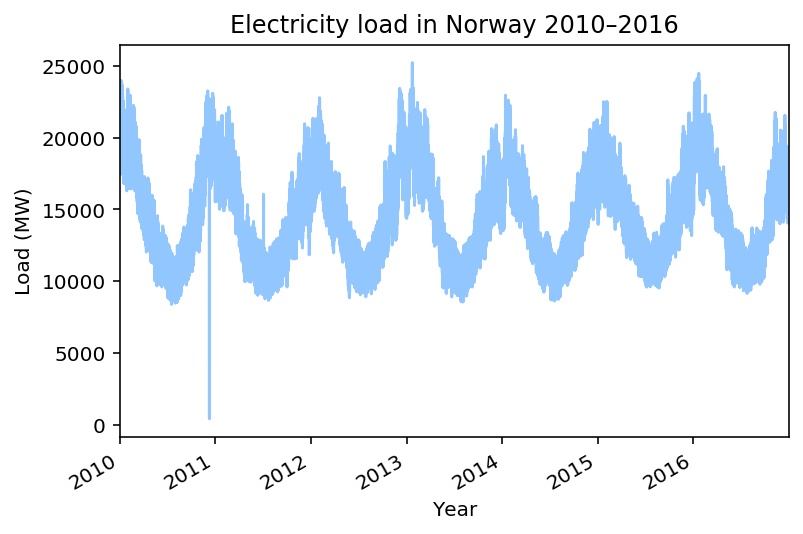

In [2]:
# Load dataset

filename = "NO_load_actual_entsoe_power_statistics.csv"
dataset = pd.read_csv(filename)
dataset.index = pd.to_datetime(dataset.datetime)
dataset = dataset.drop(columns=["datetime"])

display(dataset.head())
display(dataset.tail())

# Plot df
figure = dataset.load_mw.plot(legend=False)
figure.set(xlabel="Year", ylabel="Load (MW)", title="Electricity load in Norway 2010–2016")
figure;

### Correlation between load and temperature
Fairly strong correlation between temperature and load in Norway, as we use electricity for heating.

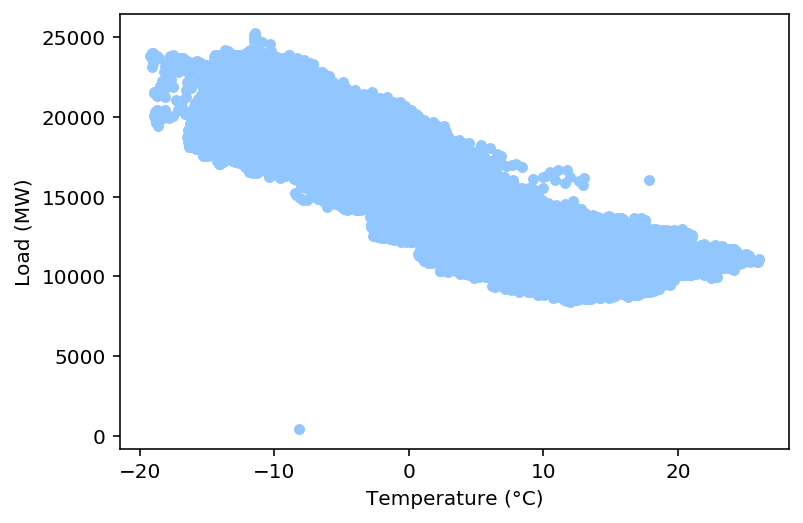

In [3]:
figure = dataset.plot.scatter(x="temp_c", y="load_mw")
figure.set(xlabel="Temperature (°C)", ylabel="Load (MW)")
figure;

## Model

#### Model setup

In [4]:
# Configure data frame so it is compatable with Fbprophet
# Dataset, except forecasting period

dataset_for_model = pd.DataFrame({
    "ds": dataset.index, 
    "y": dataset.load_mw,
    "temp": dataset.temp_c
})

# Set up model
model = fbprophet.Prophet(
    daily_seasonality=True, 
    weekly_seasonality=True, 
    yearly_seasonality=False,
    changepoint_prior_scale=0.001
)
model.add_seasonality(name='yearly', period=365.25, fourier_order=4)
model.add_country_holidays(country_name='NO')
model.add_regressor("temp")

# Fit model to data
model.fit(dataset_for_model)

# Calculate yhat and predictions
#dataset_with_future = model.make_future_dataframe(periods=forecasting_days*24, freq='H')
#dataset_with_future['temp'] = list(dataset.temp_c) # Including forcasting periode
prediction_data = model.predict(dataset_for_model)

In [5]:
# Add actual load y
prediction_data["y"] = list(dataset.load_mw)

### Model components

#### Plot of model components
Extra regressors additive == temperature

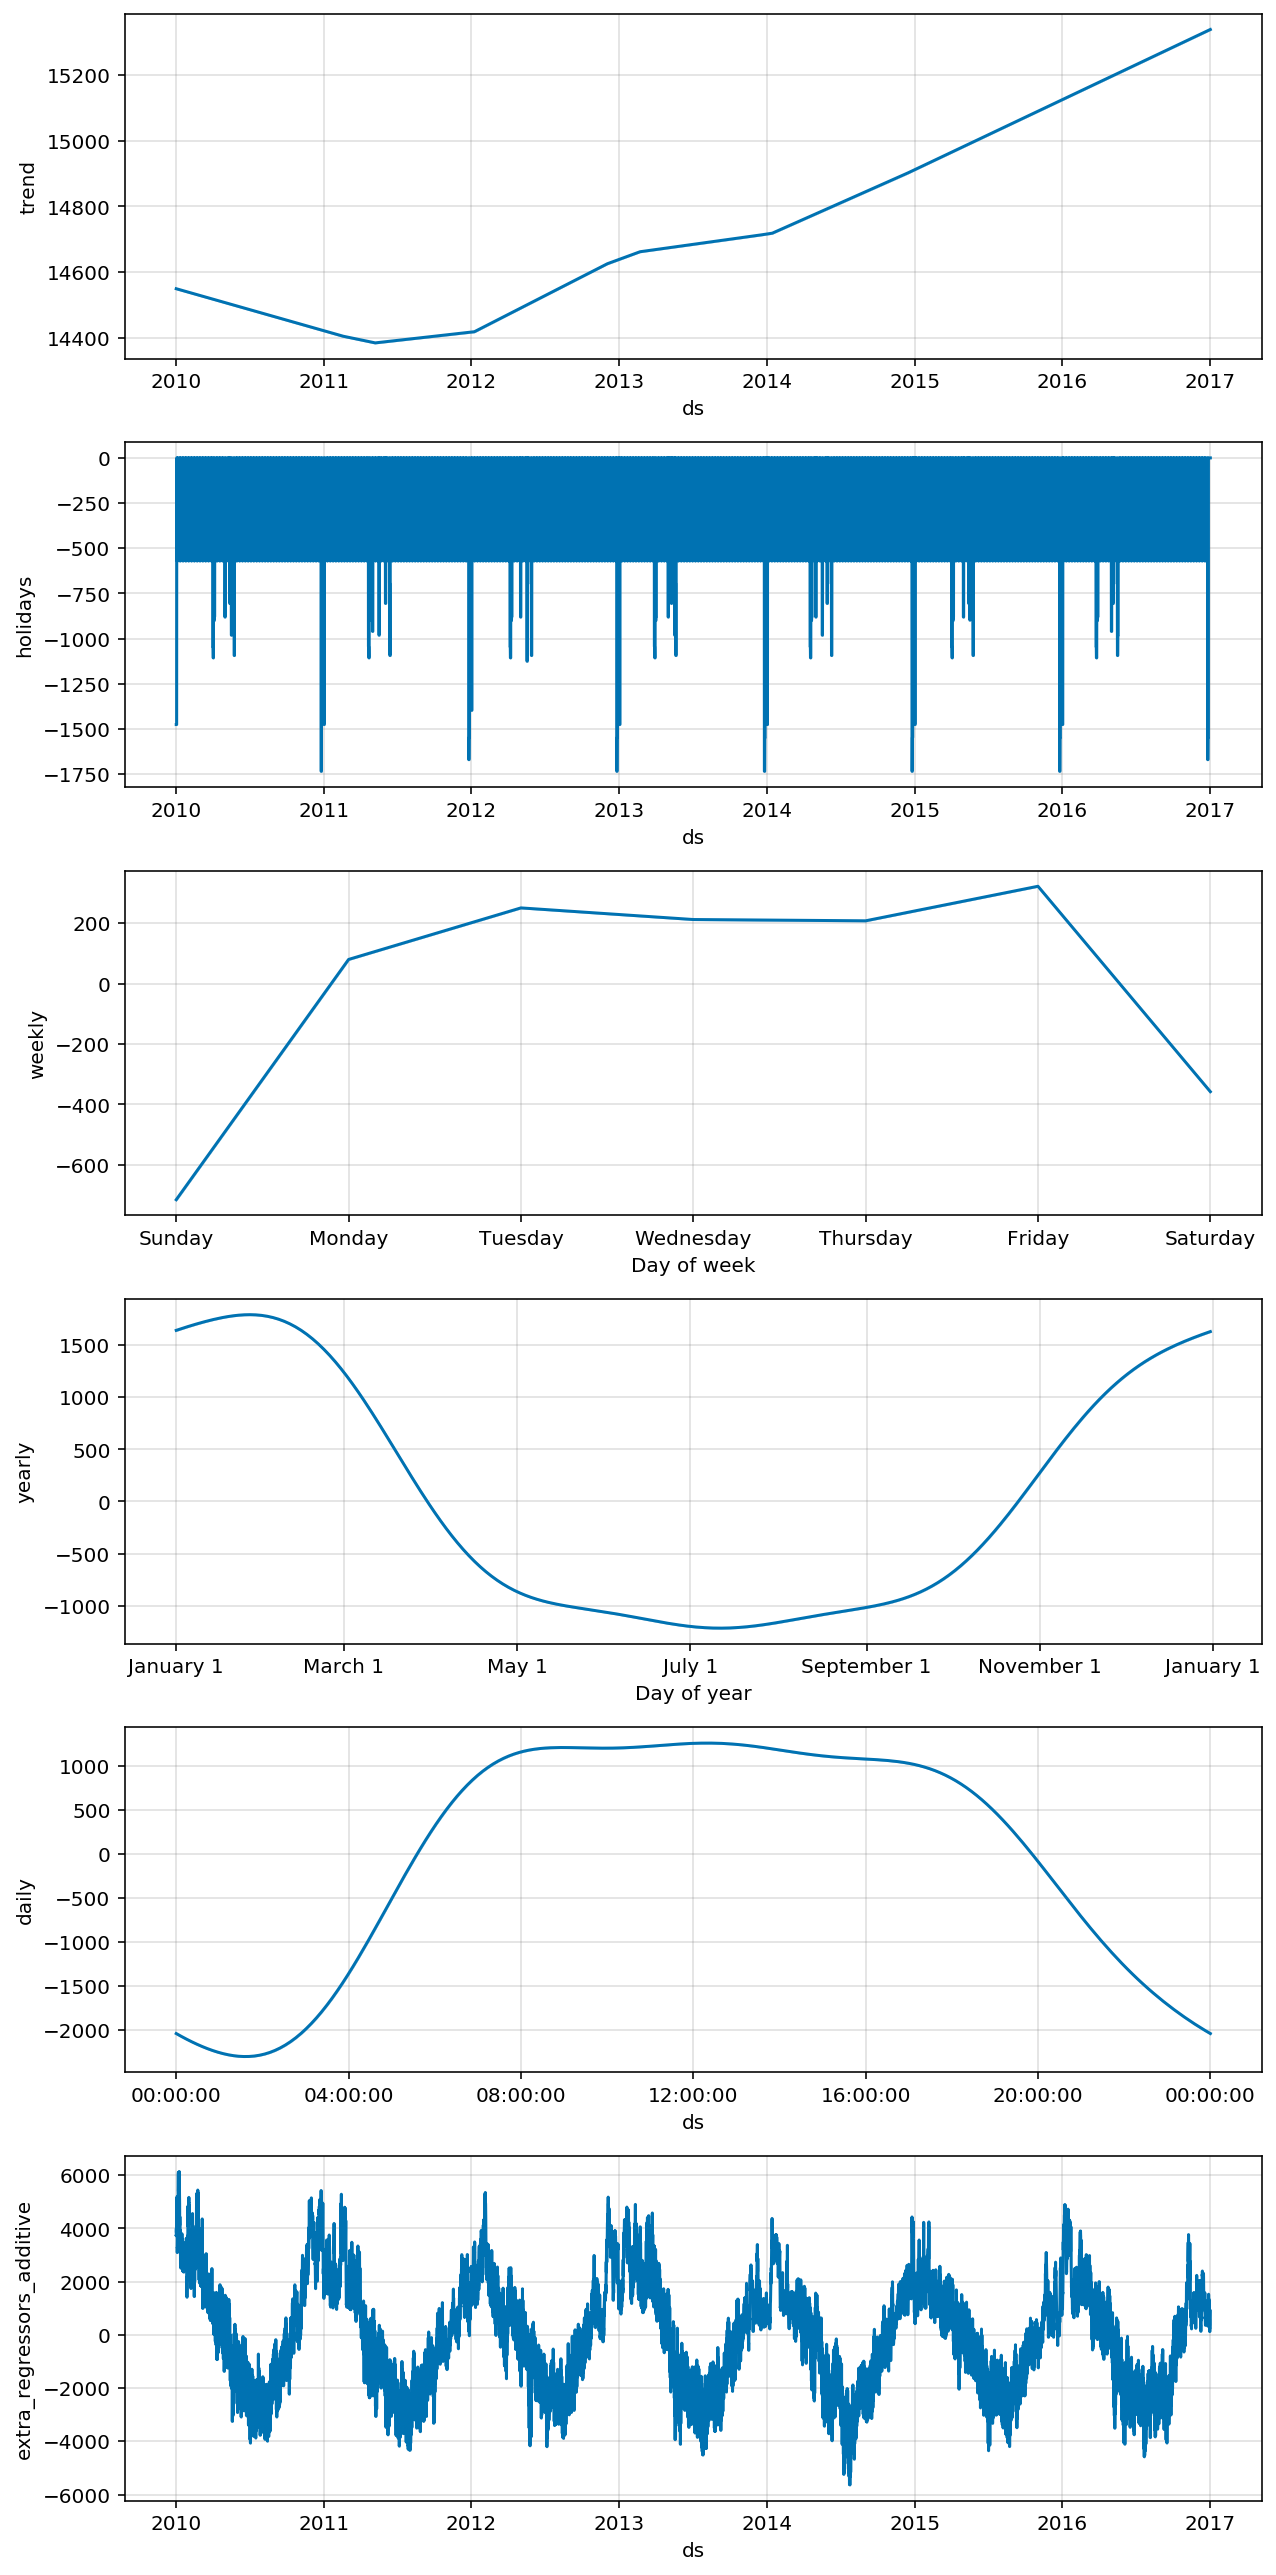

In [6]:
fig = model.plot_components(prediction_data)

## Model fit

In [7]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-01-22 23:00:00 and 2016-01-01 23:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-01-23 00:00:00,16704.017816,15935.979512,17471.513088,16070.0,2012-01-22 23:00:00
1,2012-01-23 01:00:00,16560.808936,15785.871571,17305.497065,16046.0,2012-01-22 23:00:00
2,2012-01-23 02:00:00,16600.820137,15823.040237,17399.325300,16079.0,2012-01-22 23:00:00
3,2012-01-23 03:00:00,16926.405623,16161.654323,17712.781177,16362.0,2012-01-22 23:00:00
4,2012-01-23 04:00:00,17603.174720,16889.904064,18366.555684,17078.0,2012-01-22 23:00:00



#### Plot dataset with estimated load (yhat)

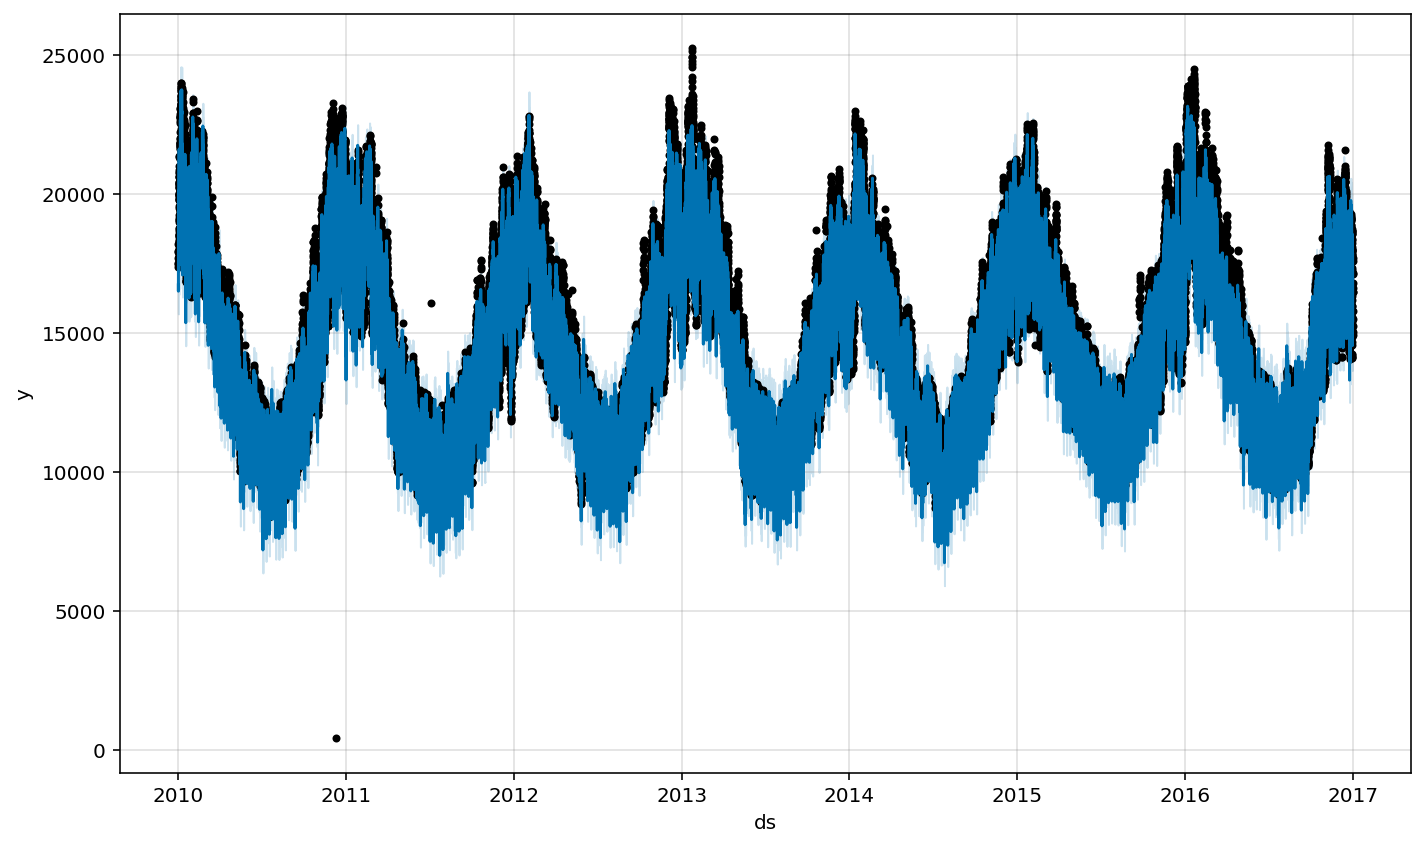

In [8]:
fig = model.plot(prediction_data)

#### One year

In [20]:
ds = pd.DataFrame({"y":df_cv.y, "yhat":df_cv.yhat})
ds.index = pd.to_datetime(df_cv.ds)

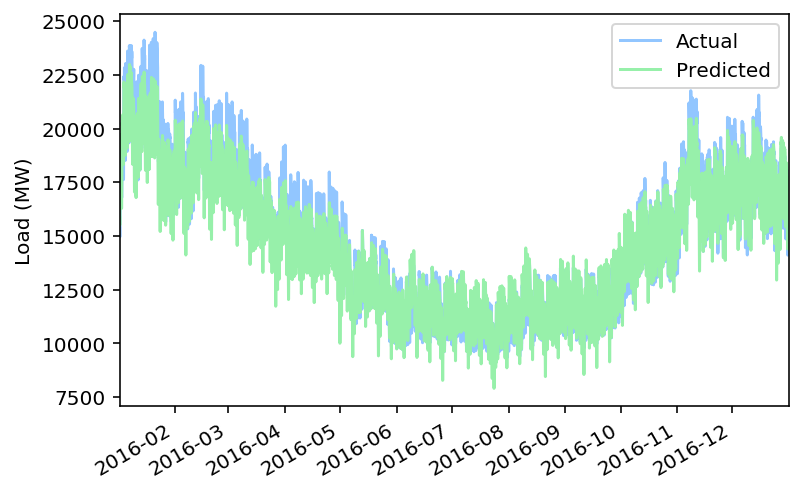

In [24]:
days = 365

# Bugfix: fbprophet deregisters some pandas plot stuff
pd.plotting.register_matplotlib_converters()

figure = ds[-days*24:].plot()
figure.set(xlabel="", ylabel="Load (MW)")
figure.legend(["Actual", "Predicted"]);
figure;

#### 14 day cold days in november

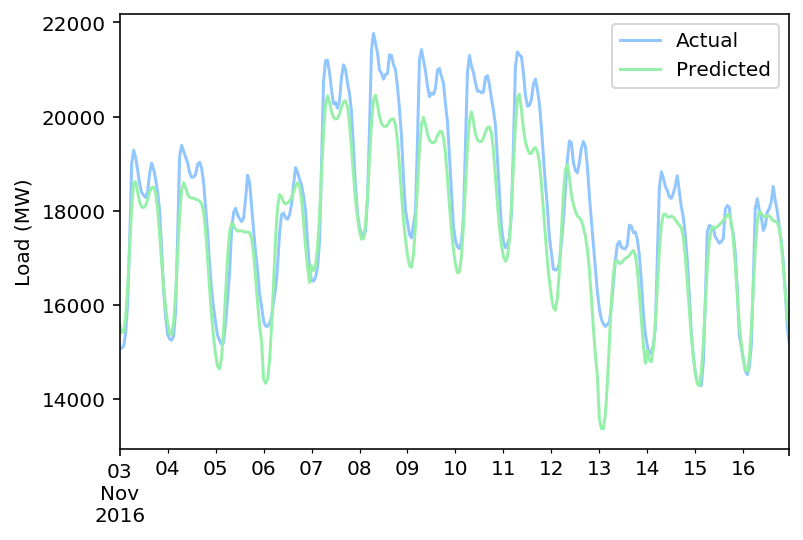

In [25]:
days_before_2016_12_31 = 45

df = df_cv
slice_of_last_14days = slice(-(days_before_2016_12_31+14)*24, -days_before_2016_12_31*24)

last_14d = pd.DataFrame({"y":df.y[slice_of_last_14days], "yhat":df.yhat[slice_of_last_14days]})
last_14d.index = pd.to_datetime(df.ds[slice_of_last_14days], utc=True)

 # Bugfix: fbprophet deregisters some pandas plot stuff
pd.plotting.register_matplotlib_converters()

figure = last_14d.plot()
figure.set(xlabel="", ylabel="Load (MW)")
figure.legend(["Actual", "Predicted"]);
figure;

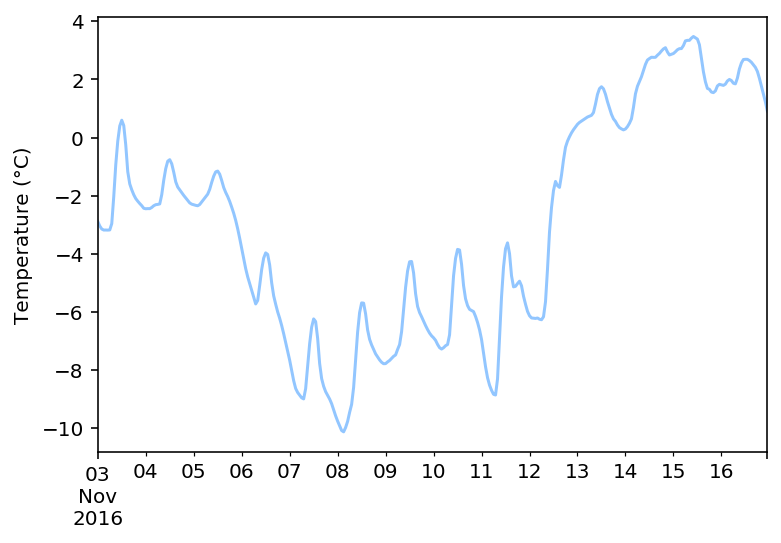

In [26]:
figure = dataset.temp_c[slice_of_last_14days].plot()
figure.set(xlabel="", ylabel="Temperature (°C)")
figure;

When the temperature fall and load rises, it looks like the model underestimates the load slightly.

#### During christmas eve

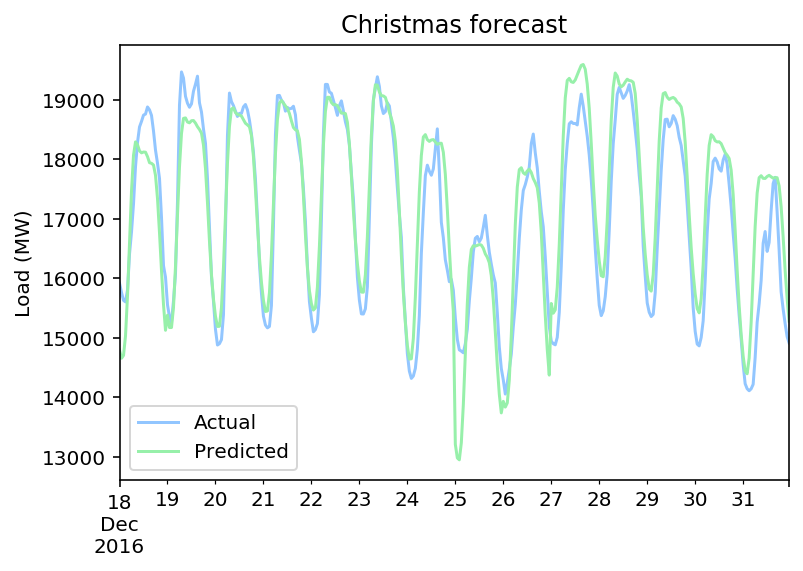

In [27]:
figure = ds[-14*24:].plot()
figure.set(xlabel="", ylabel="Load (MW)", title="Christmas forecast")
figure.legend(["Actual", "Predicted"]);
figure;

The model is quite good at estimating the decreased load around Christmas eve. However, during the non-official Christmas holiday between Dec 26–30th, the estimate is a bit too high.

#### Create scatter plot of actual and estimated load (y and yhat)

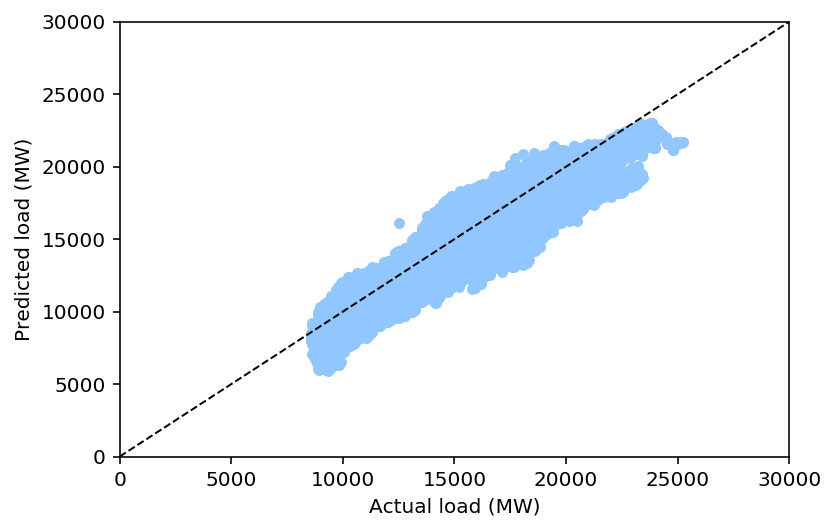

In [28]:
df = df_cv[["ds", "y", "yhat"]]

fig = df.plot.scatter(x="y", y="yhat")
fig.set(xlabel="Actual load (MW)", ylabel="Predicted load (MW)")
fig.axes.set_xlim(0, 30000)
fig.axes.set_ylim(0, 30000)
fig.plot(fig.get_xlim(), fig.get_ylim(), color='black', linestyle='--', lw=1)
fig;

# Evaluation metrics


In [29]:
print("R2 without cross validation: %.2f" % sklearn.metrics.r2_score(prediction_data.y, prediction_data.yhat))
print("R2 cross-validation 0–365 day forecasts: %.2f" % sklearn.metrics.r2_score(df_cv.y, df_cv.yhat))

R2 without cross validation: 0.96
R2 cross-validation 0–365 day forecasts: 0.92


In [30]:
from fbprophet.diagnostics import performance_metrics
df_pp = performance_metrics(df_cv, rolling_window=0.0)

In [31]:
df_pp.head(24)

,horizon,mse,rmse,mae,mape,coverage
0,0 days 01:00:00,3.660537e+05,605.023749,543.922291,0.045693,0.777778
1,0 days 02:00:00,3.284211e+05,573.080363,524.296879,0.044418,0.777778
2,0 days 03:00:00,2.979436e+05,545.842062,502.384632,0.042551,0.888889
3,0 days 04:00:00,3.711318e+05,609.205849,527.695993,0.045656,0.777778
4,0 days 05:00:00,5.178054e+05,719.586966,626.510038,0.052196,0.666667
5,0 days 06:00:00,8.480407e+05,920.891231,802.153576,0.061492,0.555556
6,0 days 07:00:00,1.586636e+06,1259.617325,1147.096237,0.075767,0.444444
7,0 days 08:00:00,1.499692e+06,1224.619198,1078.071526,0.067843,0.333333
8,0 days 09:00:00,9.721366e+05,985.969858,845.853337,0.054694,0.444444
9,0 days 10:00:00,7.063303e+05,840.434613,719.892607,0.046885,0.555556


In [32]:
# Average evaluation metrics on 12–36 hours ahead forecasted load
df_pp[12:36].mean()

horizon     1 days 00:30:00
mse                  513509
rmse                694.332
mae                 586.072
mape              0.0418239
coverage           0.740741
dtype: object

In [33]:
df_p = performance_metrics(df_cv, rolling_window=0.1)

In [34]:
# Evaluation metrics on 36 day ahead forecasted load
days=36
df_p[(days-36)*24:(days-36)*24+1]

,horizon,mse,rmse,mae,mape,coverage
0,36 days 12:00:00,642654.206273,801.657163,633.439292,0.041792,0.696601


In [35]:
# Evaluation metrics on 60 day ahead forecasted load
days=60
df_p[(days-36)*24:(days-36)*24+1]

,horizon,mse,rmse,mae,mape,coverage
576,60 days 12:00:00,411072.950508,641.14971,504.212428,0.034582,0.795662


In [36]:
# Evaluation metrics on 90 day ahead forecasted load
days=90
df_p[(days-36)*24:(days-36)*24+1]

,horizon,mse,rmse,mae,mape,coverage
1296,90 days 12:00:00,683492.046029,826.735778,617.952503,0.041852,0.717515


In [37]:
# Evaluation metrics on 180 day ahead forecasted load
df_p[178*24:182*24].mean()

horizon     216 days 11:30:00
mse                    902948
rmse                  950.212
mae                   743.284
mape                0.0572347
coverage             0.638877
dtype: object

In [38]:
# Evaluation metrics on 365 day ahead forecasted load
df_p.tail(1)

,horizon,mse,rmse,mae,mape,coverage
7884,365 days,1.275093e+06,1129.200198,831.991196,0.054016,0.62037


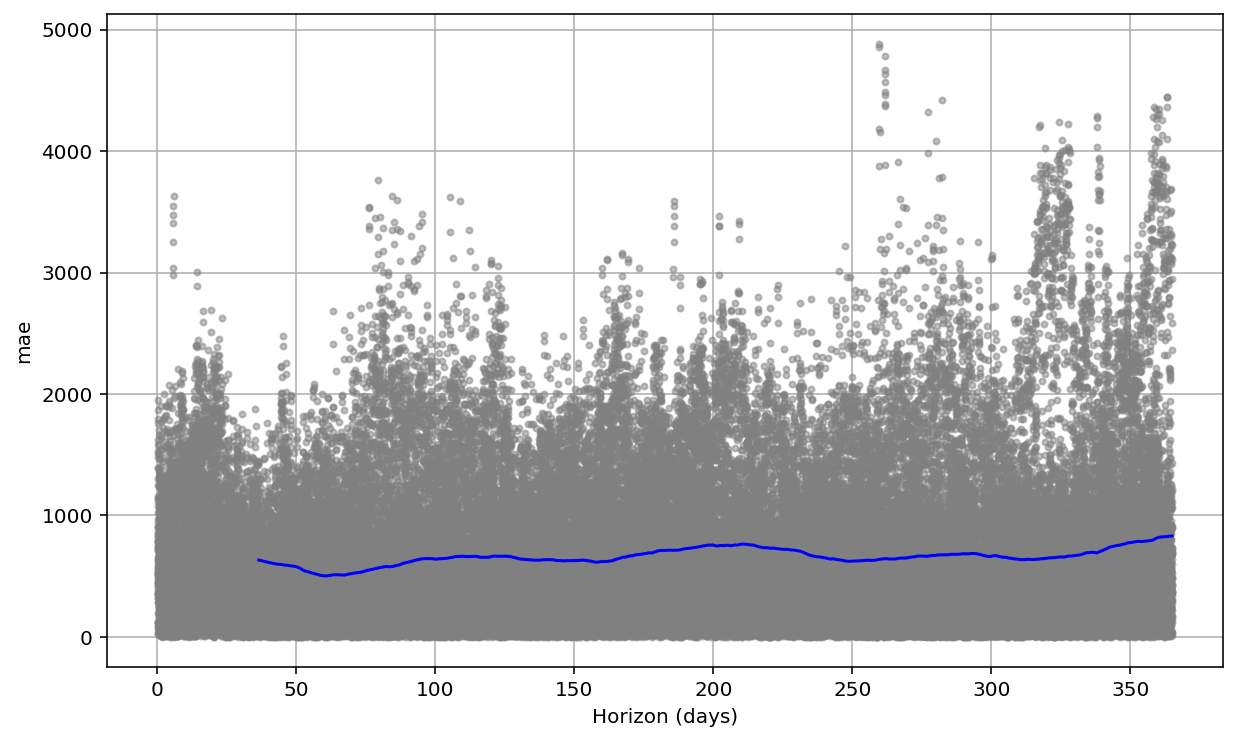

In [39]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')